## Introduction

An example of implementing the keras Node2Vec representation learning algorithm using components from the stellargraph library.

<a name="refs"></a>
**References**

[1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

[2] Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

In [1]:
from stellargraph import StellarGraph
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import backend as K
import time

### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`~/data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [2]:
# load directed graph from ordering (cited_paper, citing_paper)
data_location = os.path.expanduser("~/data/cora/")
g_nx = nx.read_edgelist(path=os.path.join(data_location,"cora.cites"), create_using=nx.DiGraph()).reverse()

# convert to undirected graph for processing
g_nx = g_nx.to_undirected()

# load the node attribute data
node_attr = pd.read_csv(os.path.join(data_location,"cora.content"), sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows() }
nx.set_node_attributes(g_nx, values, 'subject')

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx_ccs = ( g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx) )
g_nx = max(g_nx_ccs, key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))

Largest subgraph statistics: 2485 nodes, 5069 edges


### The Node2Vec algorithm

The Node2Vec algorithm introduced in [[1]](#refs) is a 2-step representation learning algorithm. The two steps are:

1. Use random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm [[2]](#refs) is used for calculating the embedding vectors.

In this implementation, we train the Node2Vec algorithm in the following two steps:

1. Generate a set of (`target`, `context`) node pairs through starting the biased random walk with a fixed length at per node. The starting nodes are taken as the target nodes and the following nodes in biased random walks are taken as context nodes. For each (`target`, `context`) node pair collected in this way, we can switch their roles to obtain a new node pair. For each (`target`, `context`) node pair, we generate 1 negative node pair.

2. Train the Node2Vec algorithm through minimizing cross-entropy loss for `target-context` pair prediction, with the predictive value obtained by performing the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node, followed by a sigmoid activation.

Construct the StellarGraph with the edge list.

In [3]:
G_nx = StellarGraph(g_nx)

Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk.

In [4]:
nodes = list(G_nx.nodes())
number_of_walks = 100
length = 10

Create the biased random walker to perform context node sampling.

In [5]:
walker = BiasedRandomWalk(G_nx, p=0.5, q=2.0)

Create the UnsupervisedSampler instance with the relevant parameters passed to it. Set the walker of the UnsupervisedSampler instance to an instance of BiasedRandomWalk.

In [6]:
unsupervised_samples = UnsupervisedSampler(
    G_nx, 
    nodes=nodes, 
    length=length, 
    number_of_walks=number_of_walks, 
    walker = walker,
    bidirectional=True, # we collect context nodes in a bidirectional way 
                        # by considering both ahead and following nodes in random walks
    context_sampling = True # we perform sampling on the length of random walks
)

Set the batch size and the number of epochs.

In [7]:
batch_size = 50
epochs = 2

Define an attri2vec training generator, which generates a batch of (index of target node, index of context node, label of node pair) pairs per iteration.

In [8]:
generator = Node2VecLinkGenerator(G_nx, batch_size)
train_gen = generator.flow(unsupervised_samples)

Build the Node2Vec model, with the dimension of learned node representations set to 128.

In [9]:
emb_size = 128
node2vec = Node2Vec(emb_size, generator=generator)

In [10]:
x_inp, x_out = node2vec.build()

W1129 17:58:43.144293 140736473342912 deprecation_wrapper.py:119] From /Users/daokun2017/Documents/Daokun/node2vec/stellargraph/layer/node2vec.py:104: The name tf.keras.initializers.RandomUniform is deprecated. Please use tf.compat.v1.keras.initializers.RandomUniform instead.

W1129 17:58:43.147497 140736473342912 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1129 17:58:43.188324 140736473342912 deprecation_wrapper.py:119] From /Users/daokun2017/Documents/Daokun/node2vec/stellargraph/layer/node2vec.py:150: The name tf.keras.initializers.TruncatedNormal is deprecated. Please use tf.compat.v1.keras.initializers.TruncatedNormal instead.

W1129 17:58:43.189285 140736473342912 de

Use the link_classification function to generate the prediction, with the 'ip' edge embedding generation method and the 'sigmoid' activation, which actually performs the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node followed by a sigmoid activation.

In [11]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the Node2Vec encoder and prediction layer into a Keras model, and specify the loss.

In [12]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

Train the model.

In [13]:
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=True,
    workers=4,
    shuffle=True,
)

W1129 17:58:43.698254 140736473342912 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
99400/99400 [==============================] - 510s 5ms/step - loss: 0.2667 - binary_accuracy: 0.8940
Epoch 2/2
99400/99400 [==============================] - 515s 5ms/step - loss: 0.1291 - binary_accuracy: 0.9625


## Visualise Node Embeddings

Build the node based model for predicting node representations from node ids and the learned parameters. Below a Keras model is constructed, with x_inp[0] as input and x_out[0] as output. Note that this model's weights are the same as those of the corresponding node encoder in the previously trained node pair classifier.

In [14]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

Get the node embeddings from node ids.

In [15]:
node_ids = list(G_nx.nodes())
node_gen = Node2VecNodeGenerator(G_nx, batch_size).flow(node_ids)
node_embeddings = embedding_model.predict_generator(node_gen, workers=4, verbose=1)

50/50 [==============================] - 0s 1ms/step


Get node labels.

In [16]:
node_targets = [ g_nx.node[node_id]['subject'] for node_id in node_ids ]

Transform the embeddings to 2d space for visualisation.

In [17]:
transform = TSNE # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

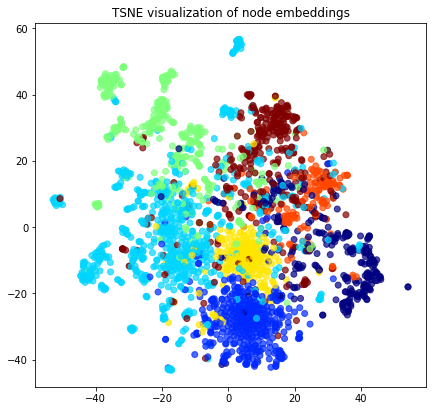

In [18]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets)) }
node_colours = [ label_map[target] for target in node_targets ]

plt.figure(figsize=(7,7))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, cmap="jet", alpha=alpha)
plt.title('{} visualization of node embeddings'.format(transform.__name__))
plt.show()

### Node Classification
In this task, we will use the `Node2Vec` node embeddings to train a classifier to predict the subject of a paper in Cora.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
# X will hold the 128-dimensional input features
X = node_embeddings  
# y holds the corresponding target values
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, test_size=None)

### Data Splitting

We split the data into train and test sets. 

We use 10% of the data for training and the remaining 90% for testing as a hold-out test set.

In [20]:
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Array shapes:
 X_train = (745, 128)
 y_train = (745,)
 X_test = (1740, 128)
 y_test = (1740,)


### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [21]:
clf = LogisticRegressionCV(
    Cs=10, 
    cv=10, 
    scoring="accuracy",
    verbose=False,
    multi_class='ovr',
    max_iter=1000
)
clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='ovr', n_jobs=None,
                     penalty='l2', random_state=None, refit=True,
                     scoring='accuracy', solver='lbfgs', tol=0.0001,
                     verbose=False)

Predict the hold-out test set.

In [22]:
y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [23]:
accuracy_score(y_test, y_pred)

0.7586206896551724